# Experiments: Broad grid of imaging parameters

The following notebook details a set of experiments done in late June on G351.77 B6 SPW7, which contains no bright lines.

Full spectral window cubes were made of the same data using parameters spanning the following:

 * `perchanweightdensity={True,False}`, specified in the filename with `_T_` or `_F_`
 * `hogbom` clean or multiscale clean.  Multiscale uses scales [0,5,15].  Hogbom is denoted `_h_`, multiscale is `m{-1.0,0.0,1.0}`.
     * the multiscale clean was imaged with smallscalebias = -1, 0, 1.  From the tclean docs: "A score larger than 0.0 will bias the solution towards smaller scales.
A score smaller than 0.0 will bias the solution towards larger scales."
 * `restoringbeam='common' or ''`, denoted as `_common_` or `_perchan_`  (shortened to `cm` or `pc`)
 * Two pixel sizes, 0.22 arcsec and 0.13 arcsec, denoted as `_bigpix_` or  `_smallpix_` (shortened to `big` or `small`)
 * Two cyclefactors, 1.0 and 2.0.  A larger cyclefactor means more major cycles.  Denoted `_cf1_` and `_cf2_`.
 * Two startmodel options: `_noSM`, no startmodel, and `_SM`, using the continuum startmodel.
 * Two "briggstaper" options: `bwt` for `weighting='briggsbwtaper'`, `rob` for `weighting='briggs'`

In [1]:
from spectral_cube import SpectralCube
from astropy import units as u, coordinates

In [2]:
cd /orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7


In [3]:
ls -lhrtd *.image

drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 13:17 G351.77_B6_spw7_12M_spw7_F_h_perchan_bigpix_cf1_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 13:29 G351.77_B6_spw7_12M_spw7_F_h_common_bigpix_cf1_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 14:22 G351.77_B6_spw7_12M_spw7_F_h_common_smallpix_cf1_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 14:27 G351.77_B6_spw7_12M_spw7_F_h_perchan_smallpix_cf1_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 16:33 G351.77_B6_spw7_12M_spw7_F_h_perchan_bigpix_cf2_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 16:39 G351.77_B6_spw7_12M_spw7_T_h_perchan_bigpix_cf2_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 17:08 G351.77_B6_spw7_12M_spw7_F_h_common_smallpix_cf2_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adamginsburg 4.0K Jun 25 17:08 G351.77_B6_spw7_12M_spw7_F_h_common_bigpix_cf2_rob_noSM.image/
drwxr-xr-x 4 adamginsburg adam

In [4]:
import warnings

In [5]:
crd = coordinates.SkyCoord('17:26:40.80 -36:08:53.2', frame='fk5', unit=(u.hour, u.deg))

In [6]:
beams = {}
censpec = {}
mxspec = {}
params = {}
img = {}
spec2 = {}
sumwt = {}
rms = {}
img1901 = {}

In [7]:
spw = 7

for imsize, cell, sznm in ((768, '0.22arcsec', 'bigpix'), ([1080,1024], '0.13arcsec', 'smallpix'), ([1080], '0.16arcsec', 'smpix')):
    for perchanweightdensity in (True, False):
        pcwd = 'T' if perchanweightdensity else 'F'
        for deconvolver in ('hogbom', 'multiscale'):
            dc = 'h' if deconvolver == 'hogbom' else 'm'
            for restoringbeam in ('', 'common'):
                rb = 'common' if restoringbeam == 'common' else 'perchan'
                for cyclefactor in (1.0, 2.0):
                    for startmodel in (f"/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/imaging_results/G351.77_B6_spw{spw}_12M_spw{spw}.contcube.model", ""):
                        if startmodel and sznm == 'smallpix':
                            # can't use this startmodel b/c wrong size
                            continue
                        sm = "SM" if startmodel else "noSM"
                        for briggs in ('briggs', 'briggsbwtaper'):
                            bwt = 'bwt' if briggs == 'briggsbwtaper' else 'rob'

                            for smallscalebias in (-1.0, 0.0, 0.5, 1.0):
                                if deconvolver == 'multiscale':
                                    dc = 'm'+str(smallscalebias)
                                else:
                                    dc = 'h'
                                for thr in ("","_th10mJy", "_th20mJy", "_th30mJy"):
                                    imname = f"/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw{spw}_12M_spw{spw}_{pcwd}_{dc}_{rb}_{sznm}_cf{int(cyclefactor)}_{bwt}_{sm}{thr}"

                                    # shorter version
                                    rbs = 'cm' if rb == 'common' else 'pc'
                                    hd = f"spw{spw}_{pcwd}_{dc}_{rbs}_{sznm.strip('pix')}_cf{int(cyclefactor)}_{sm}_{bwt}{thr}"

                                    params[hd] = {'imsize': imsize,
                                                  'cell': cell,
                                                  'perchanweightdensity': perchanweightdensity,
                                                  'deconvolver': deconvolver,
                                                  'restoringbeam': restoringbeam,
                                                  'cyclefactor': cyclefactor,
                                                  'startmodel': sm,
                                                  'smallscalebias': smallscalebias}

                                    if os.path.exists(imname+".sumwt") and hd not in sumwt:
                                        with warnings.catch_warnings():
                                            warnings.simplefilter('ignore')
                                            sw = SpectralCube.read(imname+".sumwt", format='casa_image')
                                            sumwt[hd] = sw[:,0,0]

                                    if os.path.exists(imname+".image") and hd not in img:
                                        with warnings.catch_warnings():
                                            warnings.simplefilter('ignore')
                                            cube = SpectralCube.read(imname+".image").with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=230.530*u.GHz)
                                            cube = cube.with_mask(cube>-9999*cube.unit) # HACK - error
                                            if hasattr(cube, 'beams'):
                                                beams[hd] = cube.beams
                                            else:
                                                beams[hd] = cube.beam
                                            censpec[hd] = cube[:,cube.shape[1]//2,cube.shape[2]//2]
                                            xpx,ypx = cube.wcs.celestial.wcs_world2pix(crd.ra.deg, crd.dec.deg, 0)
                                            spec2[hd] = cube[:, int(ypx), int(xpx)]
                                            img[hd] = cube[935,:,:]
                                            img1901[hd] = cube[cube.closest_spectral_channel(-1901*u.km/u.s),:,:]
                                            rms[hd] = cube[50:60,:,:].mad_std()
                                            # takes too long mxspec[hd] = cube.max(axis=(1,2))
                                            print(imname, hd)

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw7_12M_spw7_T_h_perchan_bigpix_cf1_rob_noSM spw7_T_h_pc_big_cf1_noSM_rob
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw7_12M_spw7_T_h_perchan_bigpix_cf2_rob_noSM spw7_T_h_pc_big_cf2_noSM_rob
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw7_12M_spw7_T_h_perchan_bigpix_cf2_bwt_noSM spw7_T_h_pc_big_cf2_noSM_bwt
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw7_12M_spw7_T_h_common_bigpix_cf1_bwt_noSM spw7_T_h_cm_big_cf1_noSM_bwt
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw7_12M_spw7_T_h_common_bigpix_cf2_rob_noSM spw7_T_h_cm_big_cf2_noSM_rob
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G351.77_test_June25_2021_spw7/G351.77_B6_spw7_12M_spw7_T_m1.0_common_bigpix_cf2_rob_noSM spw7_T_m1.0_cm_big_cf2_noSM_rob
/orange/adamginsburg/ALMA_IMF/2

In [8]:
len(params)

1600

In [9]:
import pylab as pl
pl.rcParams['figure.facecolor'] = (1,1,1,1)

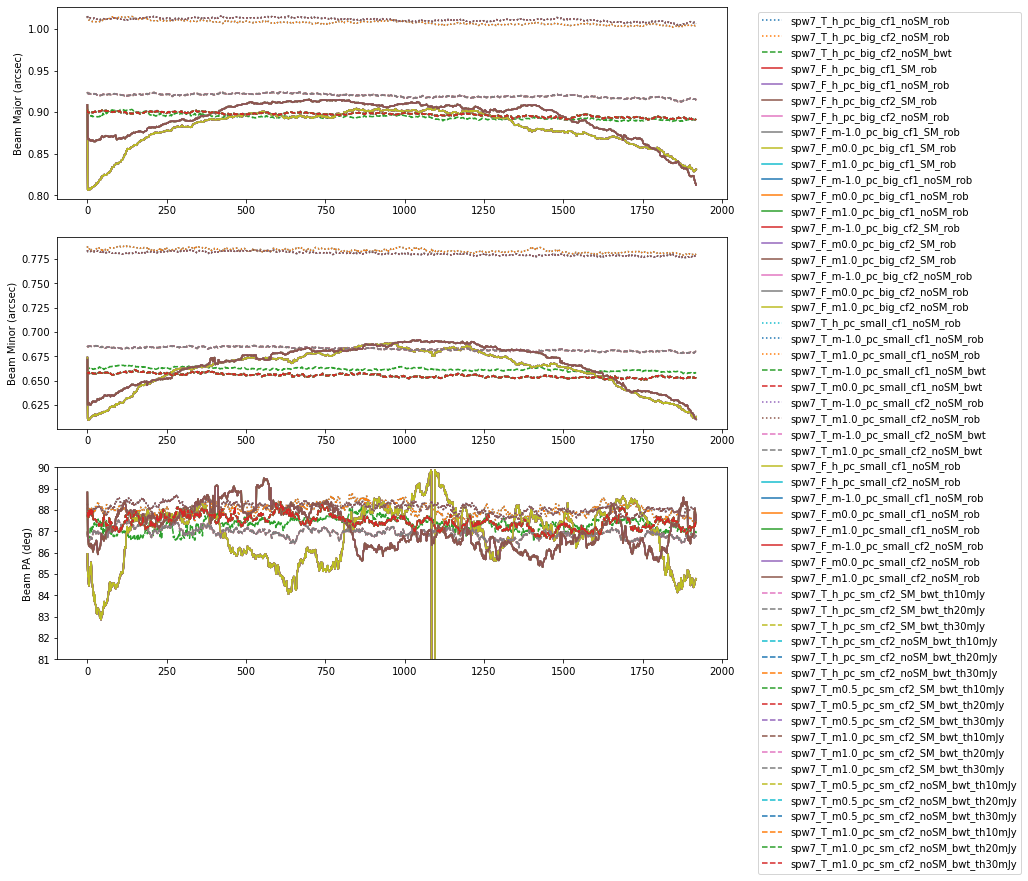

In [10]:
pl.figure(figsize=(12,12))
ax1 = pl.subplot(3,1,1)
ax2 = pl.subplot(3,1,2)
ax3 = pl.subplot(3,1,3)
for hd in beams:
    if 'bwt' in hd:
        linestyle = '--'
    elif '_T_' in hd:
        linestyle = ':'
    else:
        linestyle = '-'
    if np.isscalar(beams[hd].sr.value):
        pass
        #ax1.plot([0,1920], [beams[hd].major.value]*2, label=hd, linestyle='--')
        #ax2.plot([0,1920], [beams[hd].minor.value]*2, label=hd, linestyle=':')
        #ax3.plot([0,1920], [beams[hd].pa.to(u.deg).value]*2, label=hd, linestyle='--')
    else:
        ax1.plot(beams[hd].major, label=hd, linestyle=linestyle)
        ax2.plot(beams[hd].minor, label=hd, linestyle=linestyle)
        ax3.plot(beams[hd].pa.to(u.deg).value, label=hd, linestyle=linestyle)
ax1.set_ylabel("Beam Major (arcsec)")
ax2.set_ylabel("Beam Minor (arcsec)")
ax3.set_ylabel("Beam PA (deg)")
ax3.set_ylim([81,90])
pl.sca(ax1)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

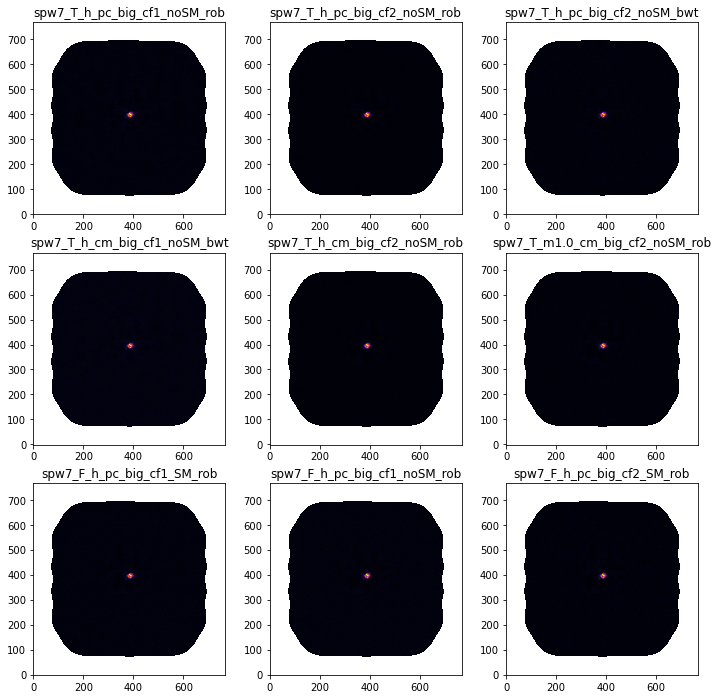

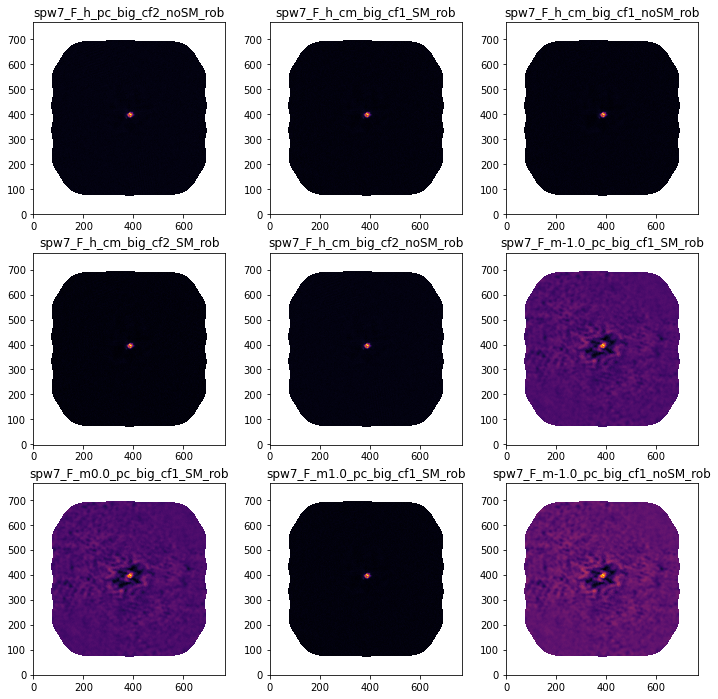

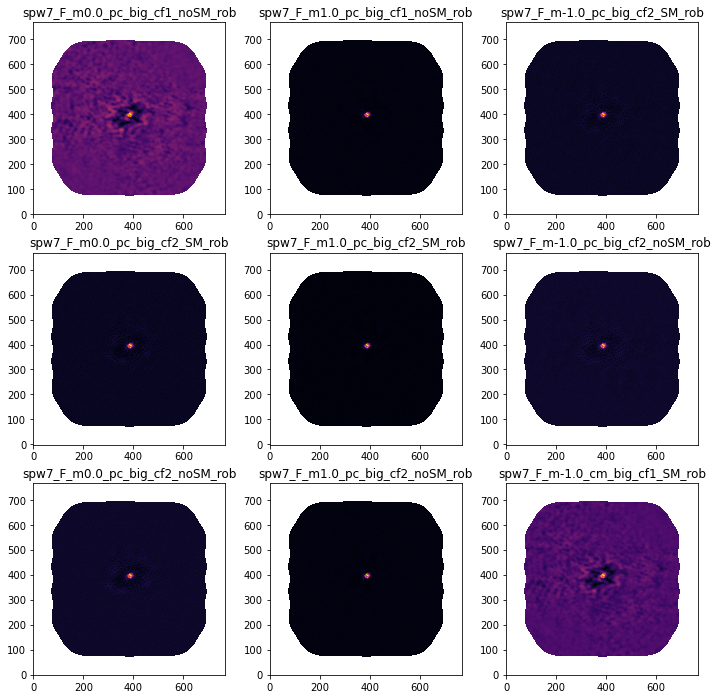

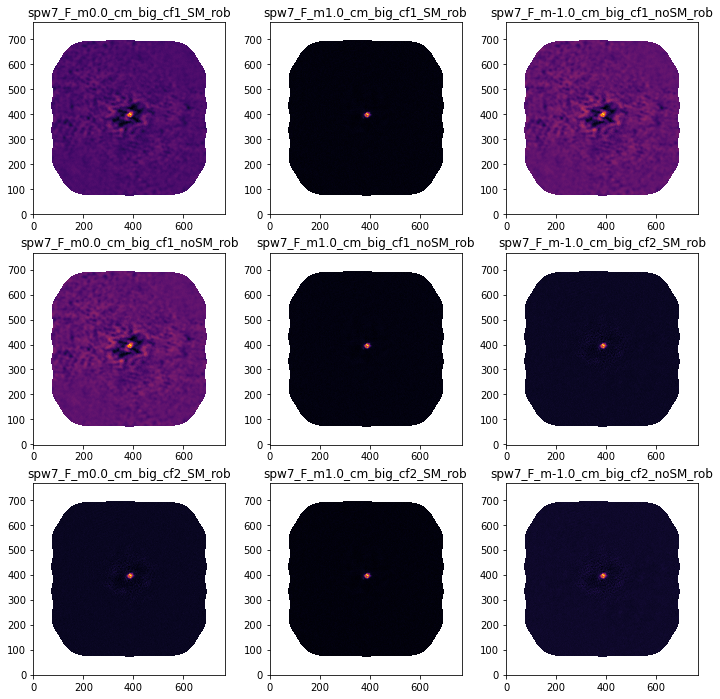

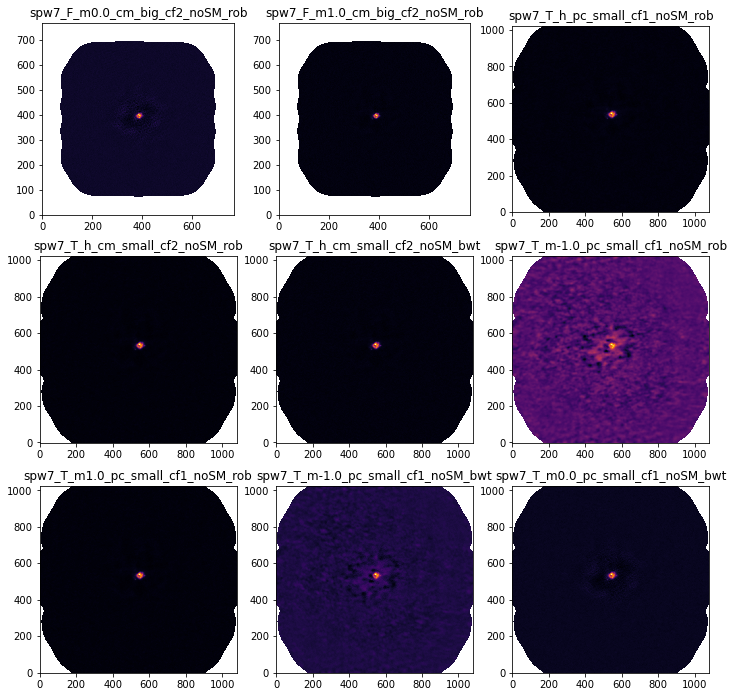

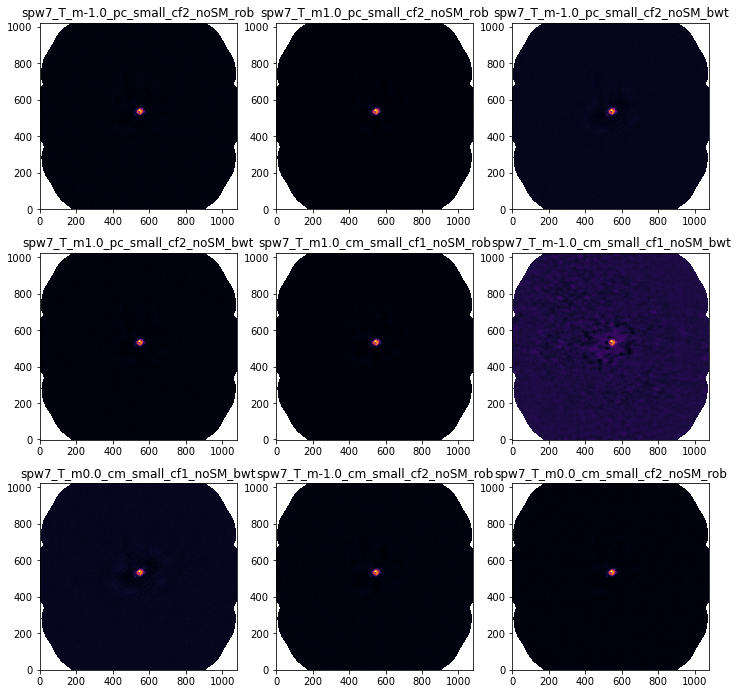

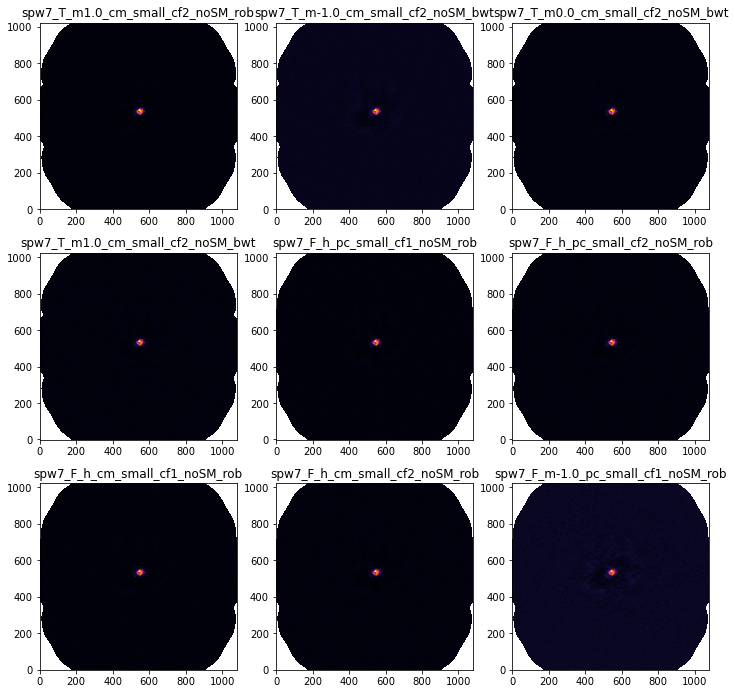

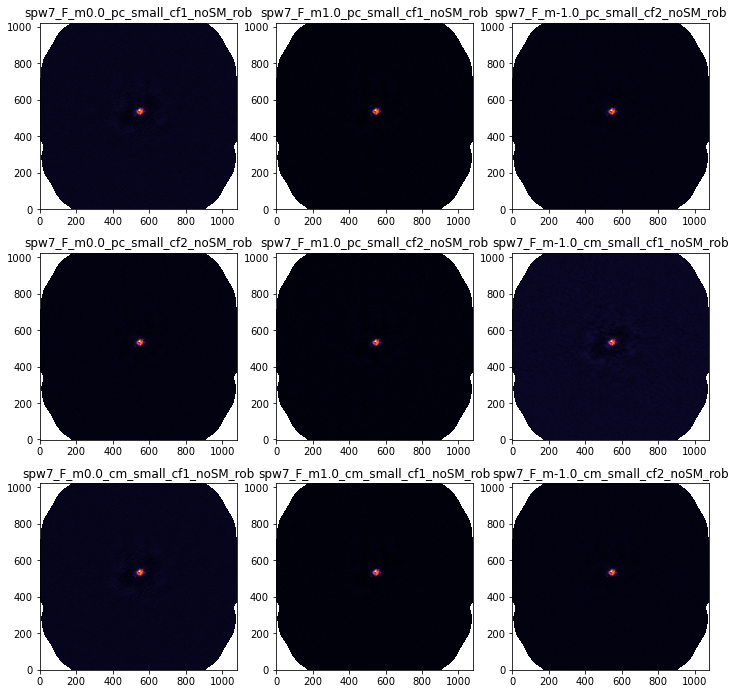

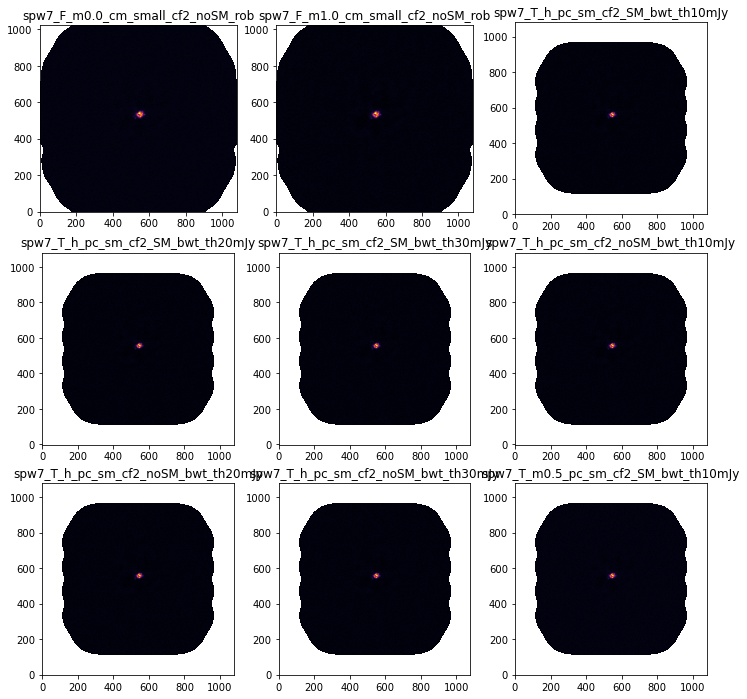

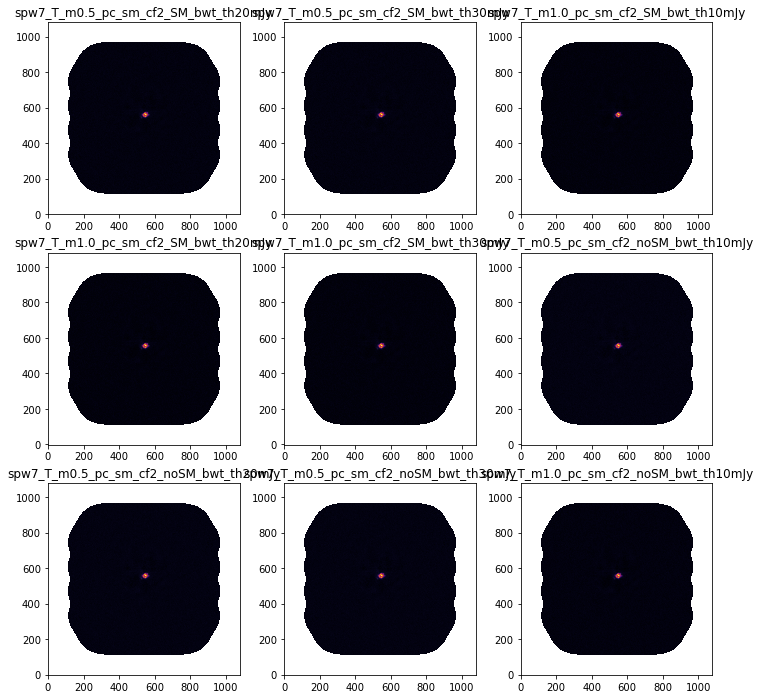

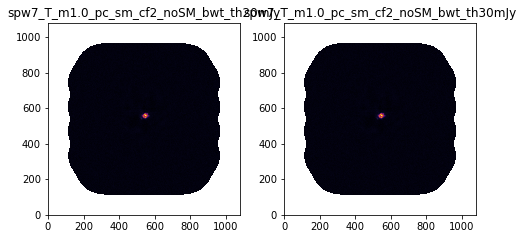

In [11]:
for ii,hd in enumerate(img):
    if ii % 9 == 0:
        pl.figure(figsize=(12,12))
    pl.subplot(3,3,ii%9+1).imshow(img[hd].value, origin='lower', interpolation='none', cmap='inferno')
    pl.title(hd)

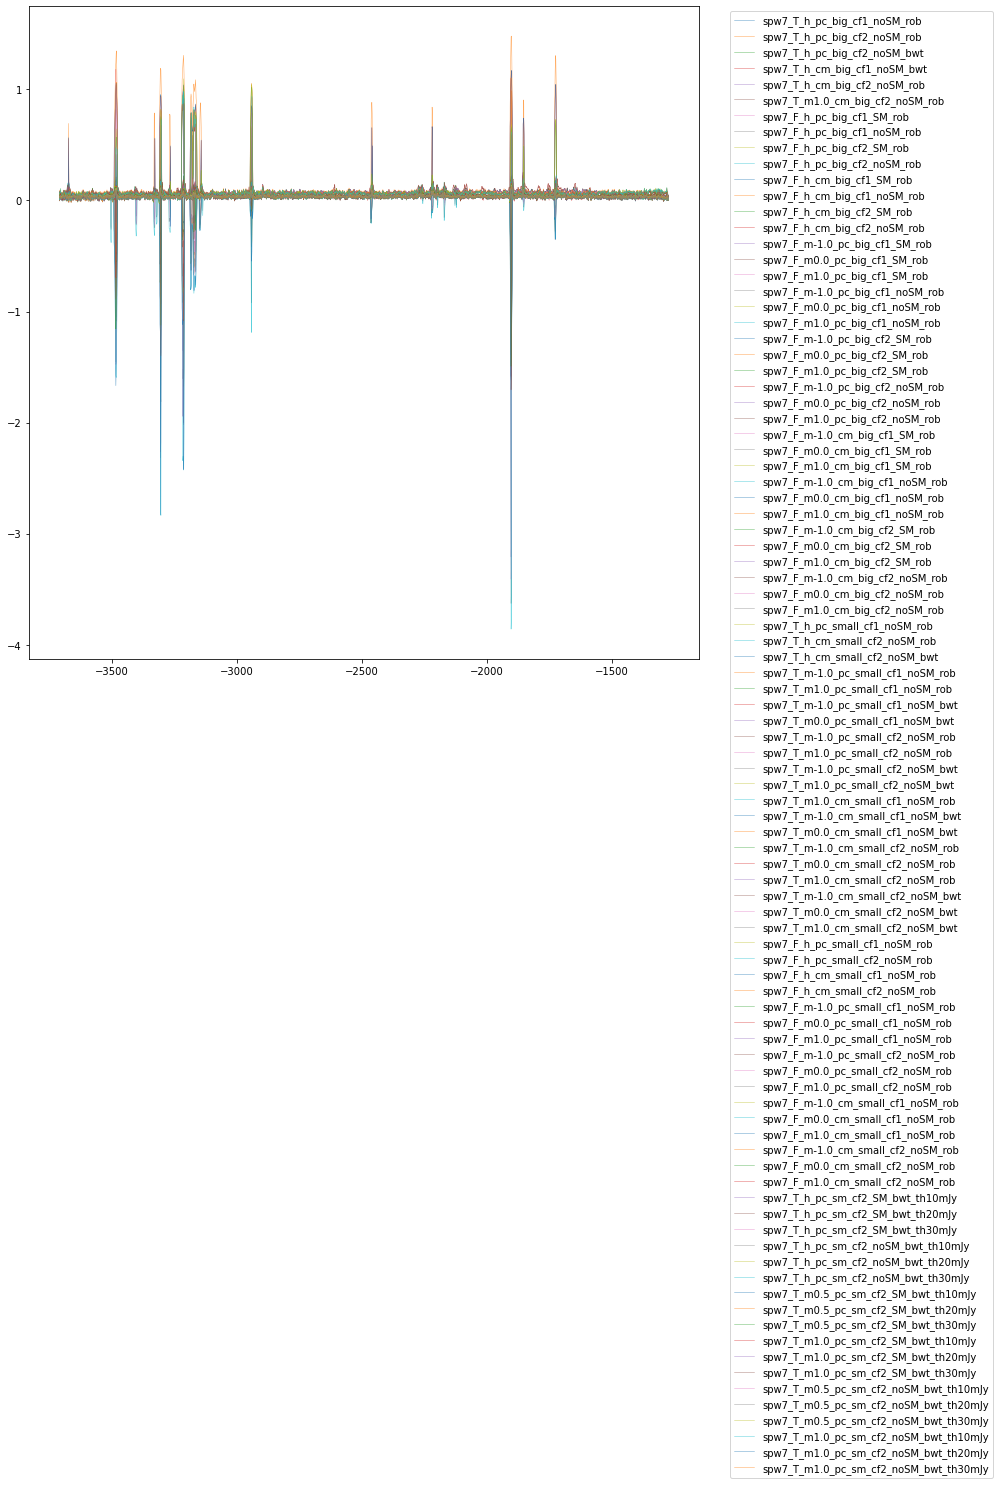

In [12]:
pl.figure(figsize=(12,12))
for hd in censpec:
    pl.plot(censpec[hd].spectral_axis, censpec[hd].value, label=hd, linewidth=0.5, alpha=0.7)
#pl.xlim(-100,50)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

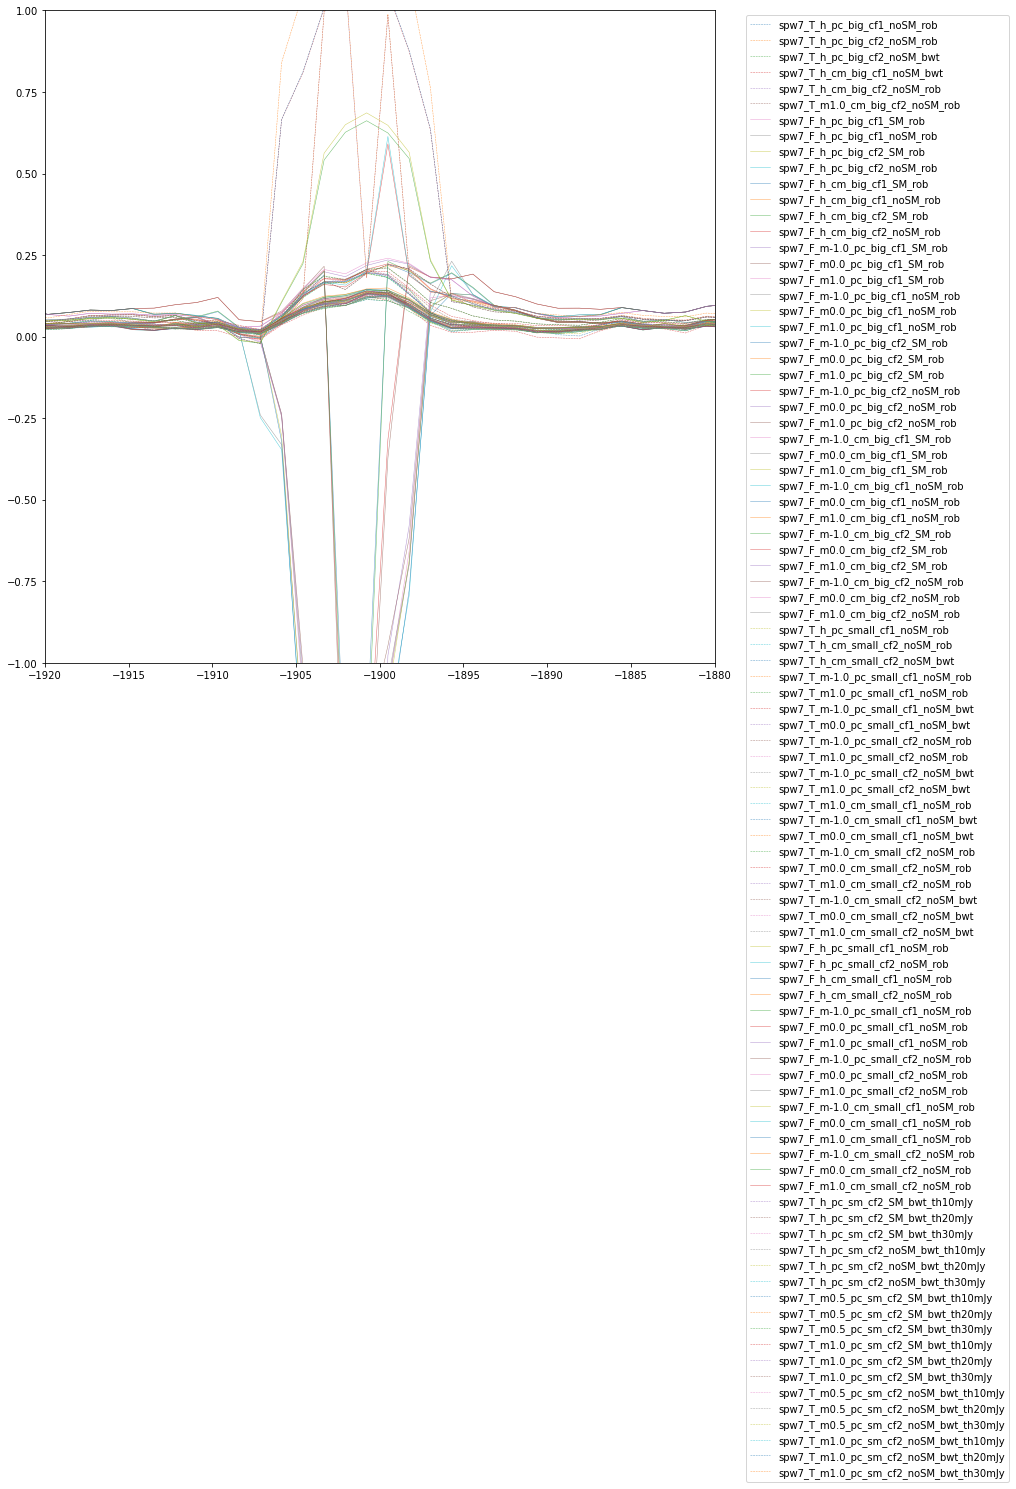

In [13]:
pl.figure(figsize=(12,12))
for hd in censpec:
    pl.plot(censpec[hd].spectral_axis, censpec[hd].value, label=hd, linewidth=0.5, alpha=0.7,
            linestyle='--' if '_T_' in hd else '-')
pl.xlim(-1920,-1880)
pl.ylim(-1,1)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

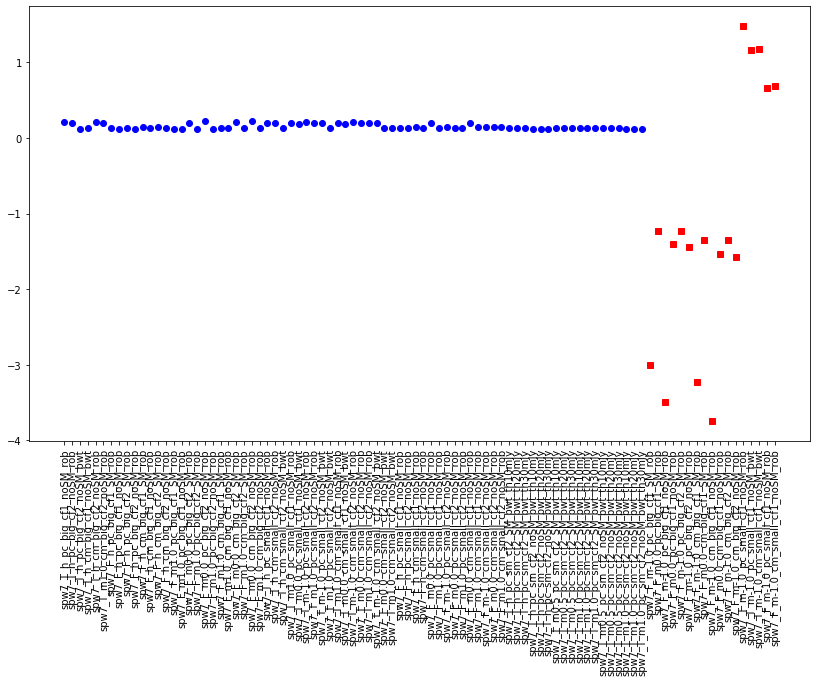

In [14]:
pl.figure(figsize=(14,8))
hdl = [hd for hd in censpec]
xx = np.array([hd for hd in hdl])
yy = np.array([censpec[hd][cube.closest_spectral_channel(-1901*u.km/u.s)].value for hd in hdl])
ok = (yy > 0.00) & (yy < 0.25)
pl.plot(xx[ok], yy[ok], 'bo')
pl.plot(xx[~ok], yy[~ok], 'rs')
_=pl.xticks(rotation=90)

In [15]:
xx[~ok]

array(['spw7_F_m-1.0_pc_big_cf1_SM_rob', 'spw7_F_m0.0_pc_big_cf1_SM_rob',
       'spw7_F_m-1.0_pc_big_cf1_noSM_rob',
       'spw7_F_m0.0_pc_big_cf1_noSM_rob',
       'spw7_F_m-1.0_pc_big_cf2_SM_rob',
       'spw7_F_m-1.0_pc_big_cf2_noSM_rob',
       'spw7_F_m-1.0_cm_big_cf1_SM_rob', 'spw7_F_m0.0_cm_big_cf1_SM_rob',
       'spw7_F_m-1.0_cm_big_cf1_noSM_rob',
       'spw7_F_m0.0_cm_big_cf1_noSM_rob',
       'spw7_F_m-1.0_cm_big_cf2_SM_rob',
       'spw7_F_m-1.0_cm_big_cf2_noSM_rob',
       'spw7_T_m-1.0_pc_small_cf1_noSM_rob',
       'spw7_T_m-1.0_pc_small_cf1_noSM_bwt',
       'spw7_T_m-1.0_cm_small_cf1_noSM_bwt',
       'spw7_F_m-1.0_pc_small_cf1_noSM_rob',
       'spw7_F_m-1.0_cm_small_cf1_noSM_rob'], dtype='<U38')

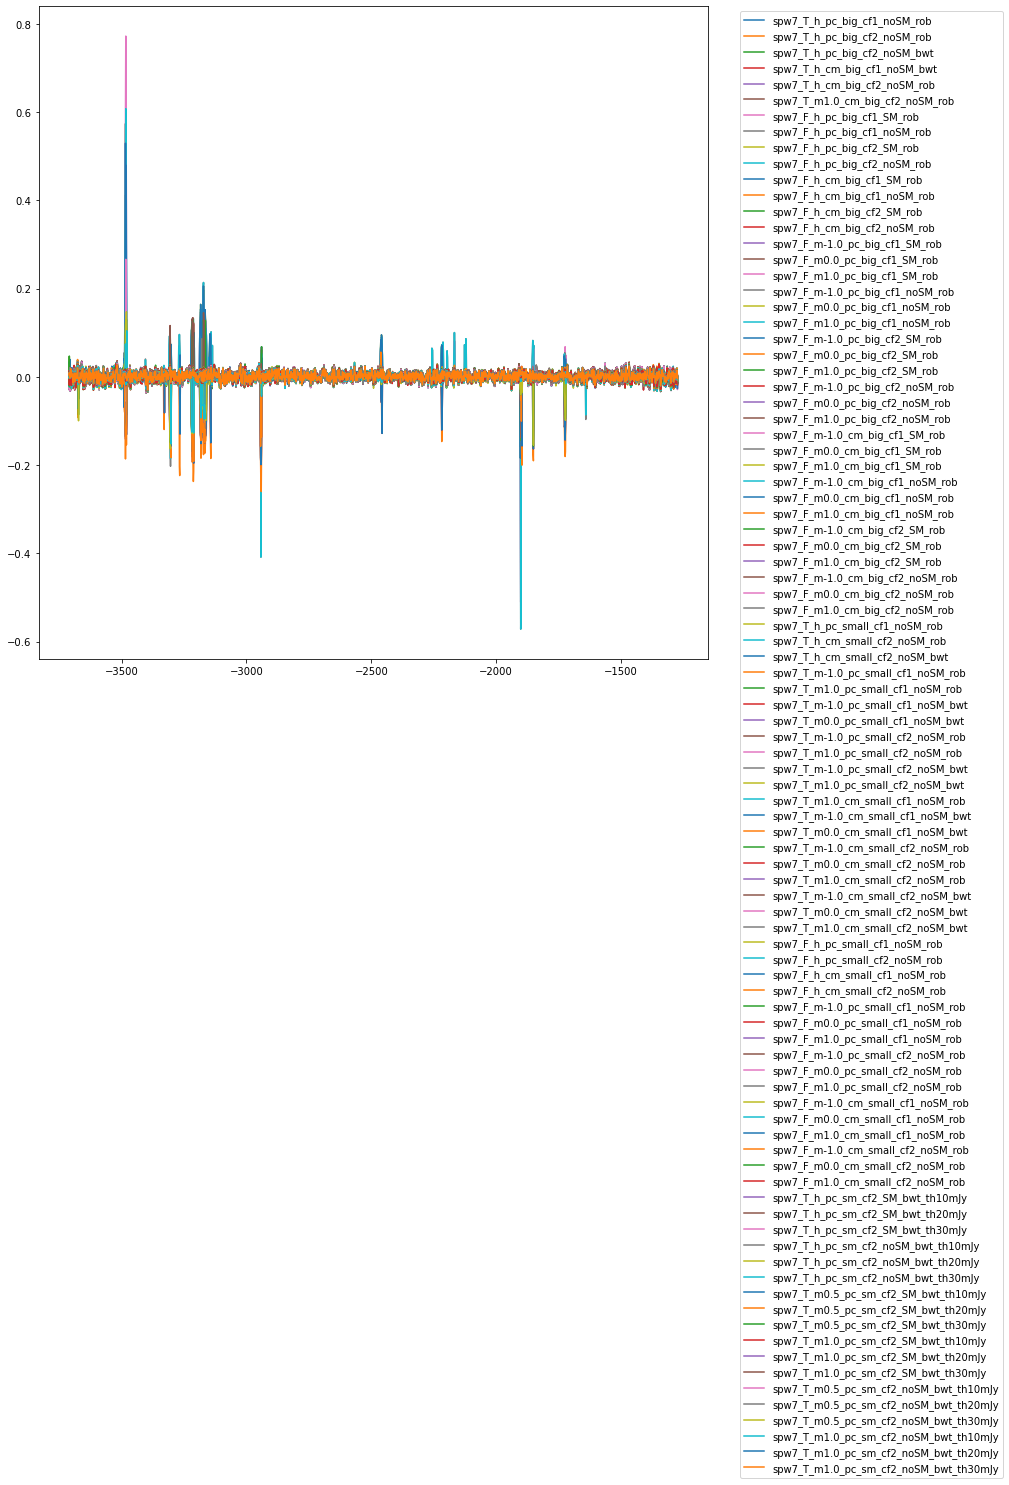

In [16]:
pl.figure(figsize=(12,12))
for hd in spec2:
    pl.plot(spec2[hd].spectral_axis, spec2[hd].value, label=hd)
#pl.xlim(-100,50)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# Sumwt

in principle, sumwt should tell us something useful about how the different channels are being weighted.  In practice, I think this is not very useful.

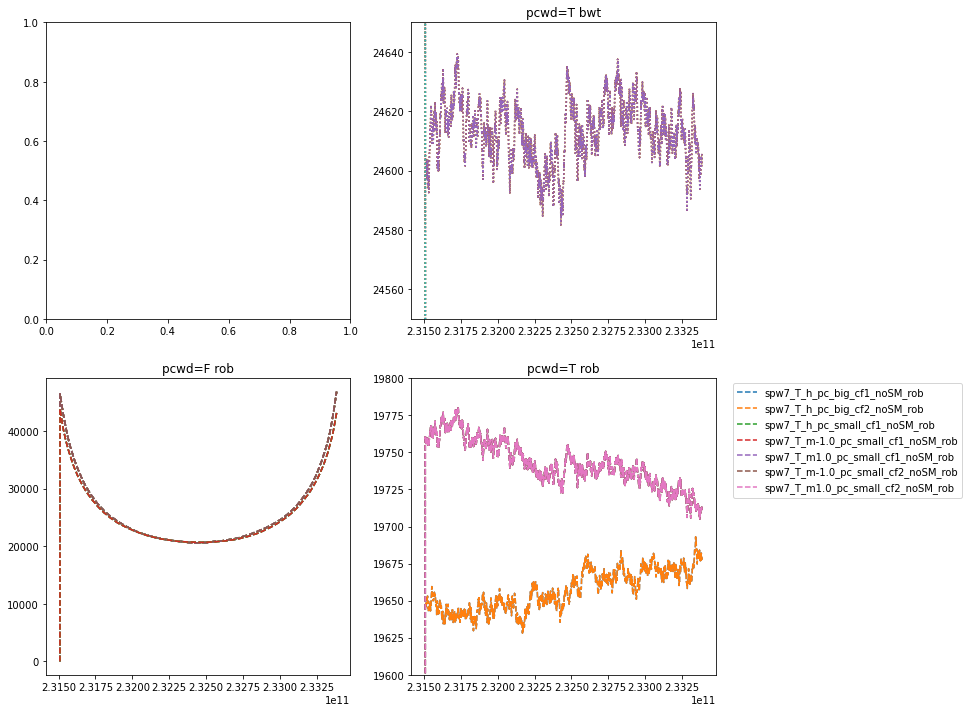

In [17]:
#pl.figure(figsize=(12,12))
fig,plots = pl.subplots(2,2, figsize=(12,12))
for hd in sumwt:
    if '_pc_' in hd:
       
        xi = 0 if 'bwt' in hd else 1

        if '_F_' in hd:
            ax = plots[xi,0]
            ax.set_title(f'pcwd=F {"bwt" if xi ==0 else "rob"}')
        else:
            ax = plots[xi,1]
            ax.set_title(f'pcwd=T {"bwt" if xi ==0 else "rob"}')
        ax.plot(sumwt[hd].spectral_axis, sumwt[hd].value, label=hd, linestyle=':' if 'bwt' in hd else '--')
plots[0,1].set_ylim(24550,24650)
plots[1,1].set_ylim(19600,19800)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

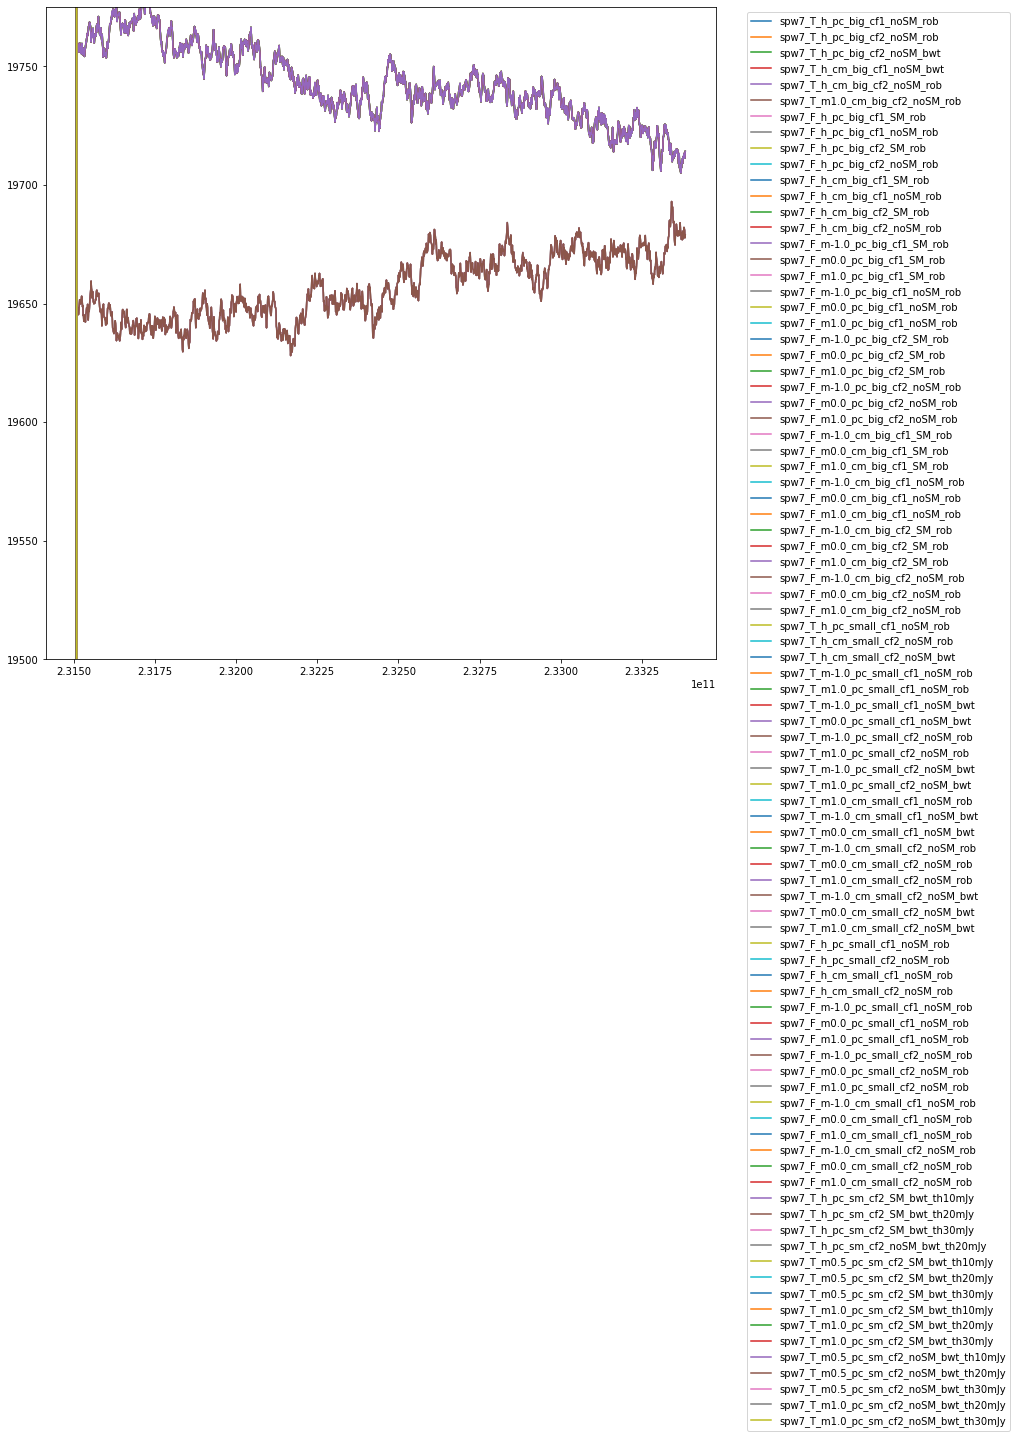

In [18]:
pl.figure(figsize=(12,12))
for hd in sumwt:
    pl.plot(sumwt[hd].spectral_axis, sumwt[hd].value, label=hd)
pl.ylim(19500,19775)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [25]:
ls -lhrtd *.weight

drwxr-xr-x 3 adamginsburg adamginsburg 4.0K Jun 25 09:47 G351.77_B6_spw7_12M_spw7_T_m1.0_perchan_smallpix_cf2_rob_noSM.weight/
drwxr-xr-x 3 adamginsburg adamginsburg 4.0K Jun 25 09:47 G351.77_B6_spw7_12M_spw7_T_h_common_bigpix_cf1_bwt_noSM.weight/
drwxr-xr-x 3 adamginsburg adamginsburg 4.0K Jun 25 09:47 G351.77_B6_spw7_12M_spw7_T_h_perchan_bigpix_cf1_rob_noSM.weight/
drwxr-xr-x 3 adamginsburg adamginsburg 4.0K Jun 25 09:47 G351.77_B6_spw7_12M_spw7_T_h_common_bigpix_cf2_rob_noSM.weight/
drwxr-xr-x 3 adamginsburg adamginsburg 4.0K Jun 25 09:47 G351.77_B6_spw7_12M_spw7_T_h_perchan_bigpix_cf2_bwt_noSM.weight/
drwxr-xr-x 3 adamginsburg adamginsburg 4.0K Jun 25 09:48 G351.77_B6_spw7_12M_spw7_T_h_perchan_bigpix_cf2_rob_noSM.weight/
drwxr-xr-x 3 adamginsburg adamginsburg 4.0K Jun 25 09:48 G351.77_B6_spw7_12M_spw7_F_h_common_bigpix_cf2_rob_noSM.weight/
drwxr-xr-x 3 adamginsburg adamginsburg 4.0K Jun 25 09:48 G351.77_B6_spw7_12M_spw7_T_m1.0_common_bigpix_cf2_rob_noSM.weight/
drwxr-xr-x 3 adamgin

In [30]:
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b78ce1ae3c8>

/home/adamginsburg/.local/lib/python3.6/site-packages/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/home/adamginsburg/.local/lib/python3.6/site-packages/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/home/adamginsburg/.local/lib/python3.6/site-packages/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


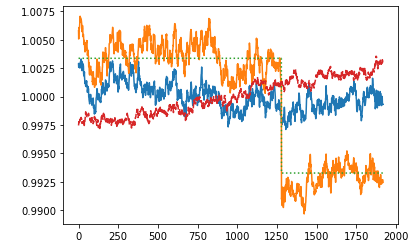

In [44]:
wcube = SpectralCube.read('G351.77_B6_spw7_12M_spw7_T_h_common_bigpix_cf1_bwt_noSM.weight', format='casa_image')
pbcube = SpectralCube.read('G351.77_B6_spw7_12M_spw7_T_h_common_bigpix_cf1_bwt_noSM.pb', format='casa_image')
sw = SpectralCube.read('G351.77_B6_spw7_12M_spw7_T_h_common_bigpix_cf1_bwt_noSM.sumwt', format='casa_image')
pl.plot(pbcube.filled_data[1:,384,384] / pbcube.filled_data[1:,384,384].mean())
pl.plot(wcube[1:,384,384] / wcube[1:,384,384].mean())
wsum = wcube[1:].sum(axis=(1,2))
pl.plot(wsum / wsum.mean(), ':')
pl.plot(sw[1:,0,0] / sw[1:,0,0].mean(), '--')

In [50]:
pbcube.shape

(1920, 768, 768)

In [51]:
1251*768*768

737869824

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

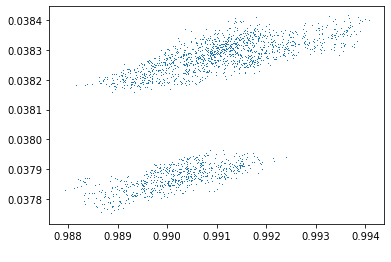

In [47]:
pl.plot(pbcube.filled_data[1:,384,384], wcube[1:,384,384], ',')
pl.plot(sorted(pbcube.filled_data[1:,384,384]), (sorted(pbcube.filled_data[1:,384,384]))**2)
pl.xlabel("PB")
pl.ylabel("Weight")

Text(0, 0.5, 'Weight')

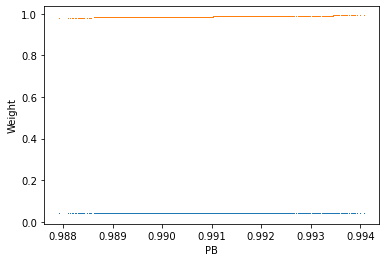

In [48]:
pl.plot(pbcube.filled_data[1:,384,384], wcube[1:,384,384], ',')
pl.plot((pbcube.filled_data[1:,384,384]), ((pbcube.filled_data[1:,384,384]))**2, ',')
pl.xlabel("PB")
pl.ylabel("Weight")

/home/adamginsburg/.local/lib/python3.6/site-packages/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/home/adamginsburg/.local/lib/python3.6/site-packages/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/home/adamginsburg/.local/lib/python3.6/site-packages/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


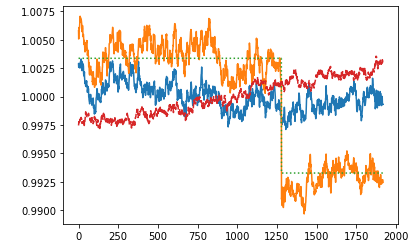

In [45]:
wcube = SpectralCube.read('G351.77_B6_spw7_12M_spw7_T_h_common_bigpix_cf1_bwt_noSM.weight', format='casa_image')
pbcube = SpectralCube.read('G351.77_B6_spw7_12M_spw7_T_h_common_bigpix_cf1_bwt_noSM.pb', format='casa_image')
sw = SpectralCube.read('G351.77_B6_spw7_12M_spw7_T_h_common_bigpix_cf1_bwt_noSM.sumwt', format='casa_image')
pl.plot(pbcube.filled_data[1:,384,384] / pbcube.filled_data[1:,384,384].mean())
pl.plot(wcube[1:,384,384] / wcube[1:,384,384].mean())
wsum = wcube[1:].sum(axis=(1,2))
pl.plot(wsum / wsum.mean(), ':')
pl.plot(sw[1:,0,0] / sw[1:,0,0].mean(), '--')

/home/adamginsburg/.local/lib/python3.6/site-packages/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/home/adamginsburg/.local/lib/python3.6/site-packages/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


Skipped sm_rob_T


/home/adamginsburg/.local/lib/python3.6/site-packages/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


Skipped big_bwt_T
Skipped sm_bwt_T


/home/adamginsburg/.local/lib/python3.6/site-packages/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/home/adamginsburg/.local/lib/python3.6/site-packages/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


Skipped sm_rob_F


Skipped big_bwt_F
Skipped sm_bwt_F
Skipped small_bwt_F


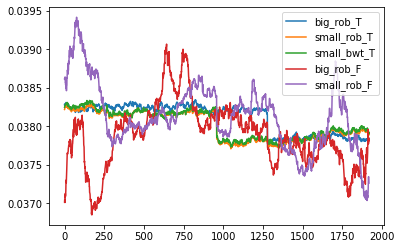

In [38]:
for pcwd, linestyle in (('T', ':'),('F','--')):
    for robust, linewidth in (('rob', 3), ('bwt', 2)):
        for pix, color in (('big', 'k'), ('sm', 'b'), ('small', 'r')):
            try:
                wcube = SpectralCube.read(f'G351.77_B6_spw7_12M_spw7_{pcwd}_h_common_{pix}pix_cf2_{robust}_noSM.weight', format='casa_image')
                ny,nx = wcube.shape[1:]
                spc = wcube[1:,ny//2,nx//2]
                pl.plot(spc, label=f'{pix}_{robust}_{pcwd}')
            except:
                print(f"Skipped {pix}_{robust}_{pcwd}")
pl.legend(loc='best')

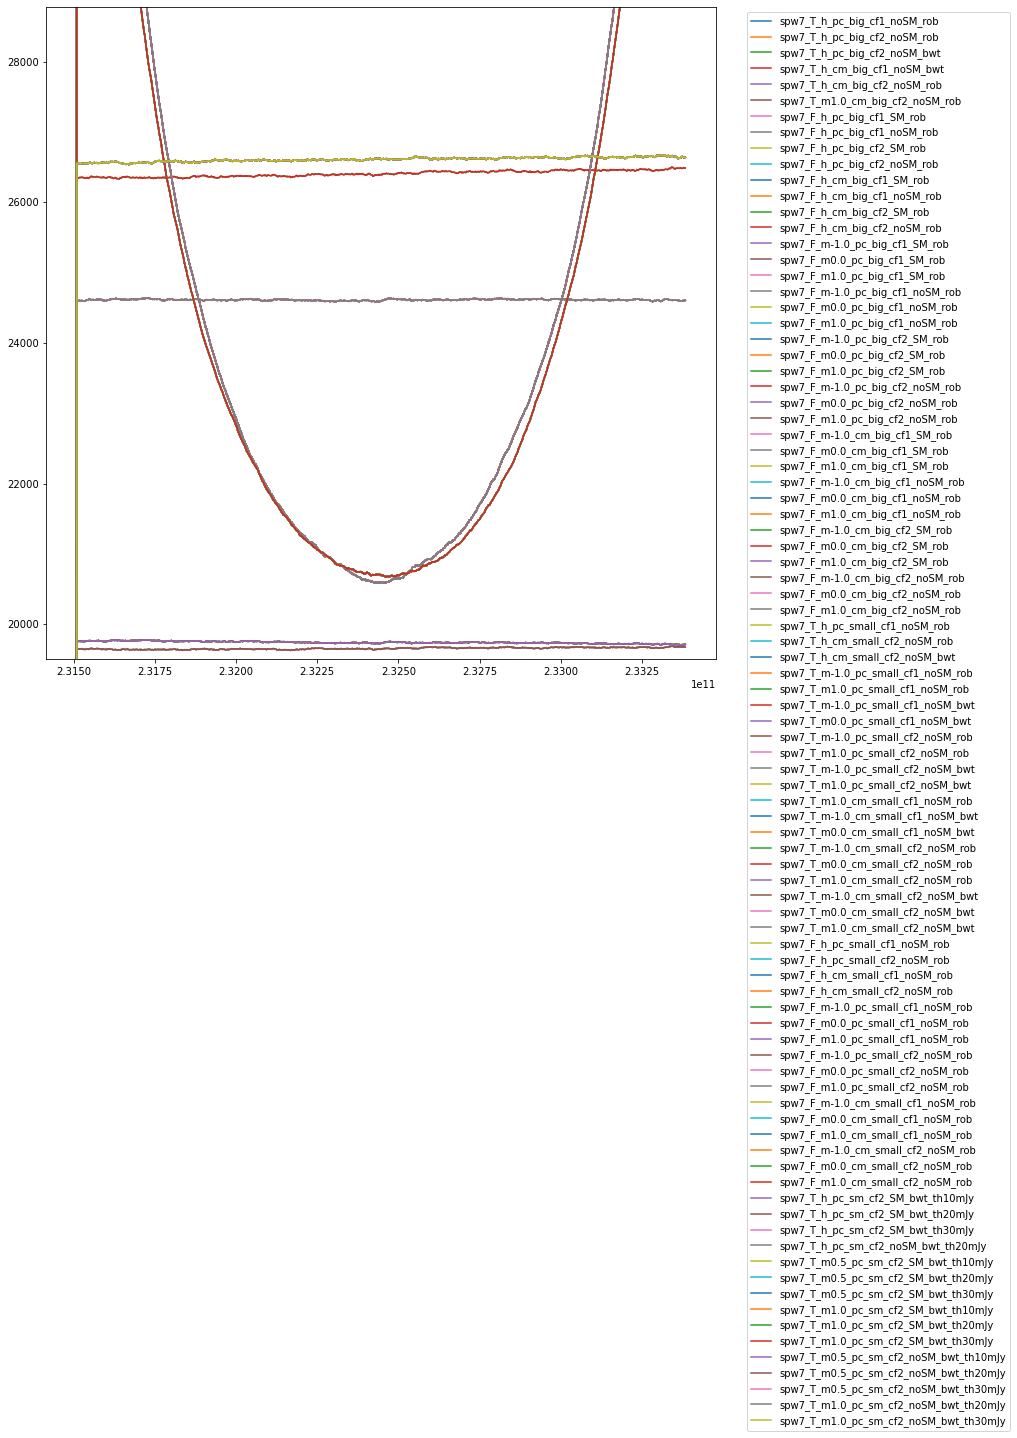

In [23]:
pl.figure(figsize=(12,12))
for hd in sumwt:
    pl.plot(sumwt[hd].spectral_axis, sumwt[hd].value, label=hd)
pl.ylim(19500,28775)
pl.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# RMS

These plots show the measured RMS for each of the reductions.  The first is the raw RMS:

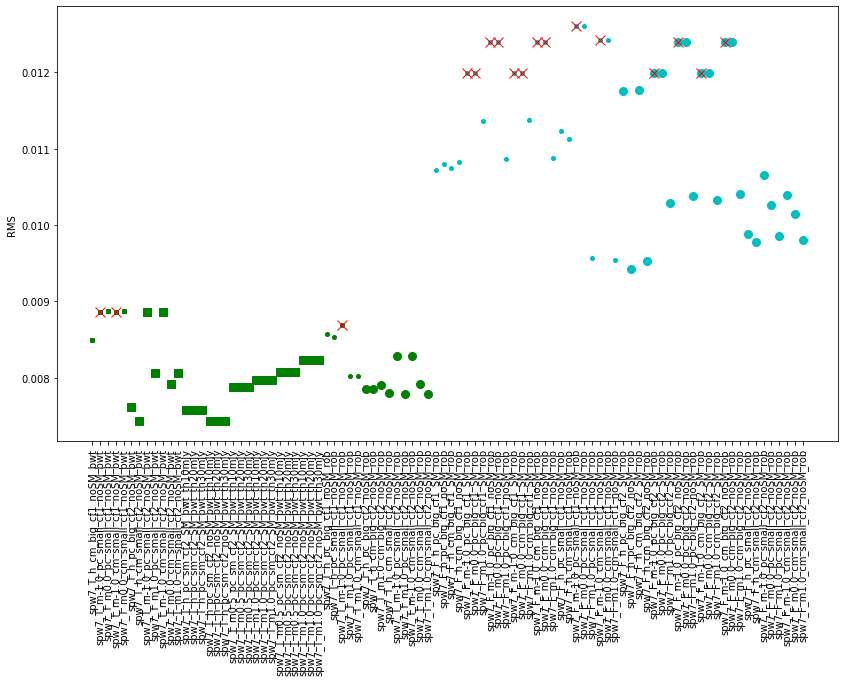

In [19]:
pl.figure(figsize=(14,8))
hdl = [hd for hd in censpec]
xx = np.array([hd for hd in hdl])
yy = np.array([rms[hd].value for hd in hdl])
#ok = (yy > 0.00) & (yy < 0.25)
colors = {'_T_': 'g', '_F_': 'c'}
shapes = {'_bwt': 's', '_rob': 'o'}
sz = {'cf1': 4, 'cf2': 8}
for cc in colors:
    for ss in shapes:
        for size in sz:
            sel = np.array([(ss in hd) and (cc in hd) and (size in hd) for hd in hdl], dtype='bool')
            pl.plot(xx[sel], yy[sel], color=colors[cc], marker=shapes[ss], markersize=sz[size], linestyle='none')
            pl.plot(xx[sel&~ok], yy[sel&~ok], color='r', marker='x', markersize=10, linestyle='none')
pl.ylabel("RMS")
_=pl.xticks(rotation=90)

...the second is the RMS divided by the beam area (so the Y-axis is arbitrary)

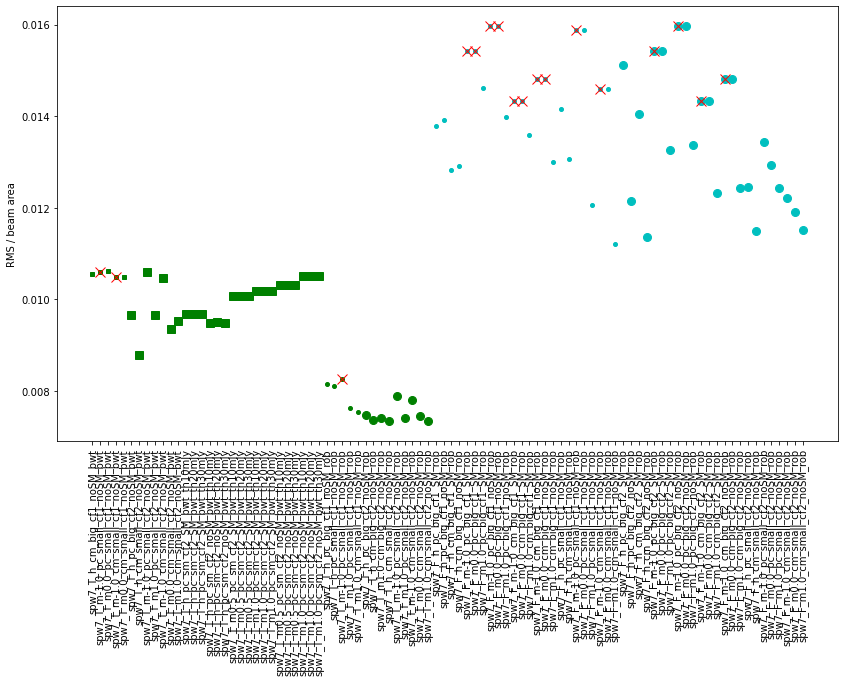

In [20]:
pl.figure(figsize=(14,8))
hdl = [hd for hd in censpec]
xx = np.array([hd for hd in hdl])
yy = np.array([rms[hd].value/beams[hd].mean().value*2e-11 for hd in hdl])
for cc in colors:
    for ss in shapes:
        for size in sz:
            sel = np.array([(ss in hd) and (cc in hd) and (size in hd) for hd in hdl], dtype='bool')
            pl.plot(xx[sel], yy[sel], color=colors[cc], marker=shapes[ss], markersize=sz[size], linestyle='none')
            pl.plot(xx[sel&~ok], yy[sel&~ok], color='r', marker='x', markersize=10, linestyle='none')
pl.ylabel("RMS / beam area")
_=pl.xticks(rotation=90)

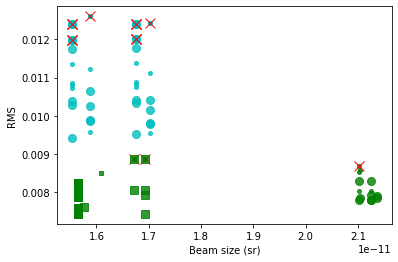

In [21]:
xx = np.array([beams[hd].mean().value for hd in hdl])
yy = np.array([rms[hd].value for hd in hdl])
for cc in colors:
    for ss in shapes:
        for size in sz:
            sel = np.array([(ss in hd) and (cc in hd) and (size in hd) for hd in hdl], dtype='bool')
            pl.plot(xx[sel], yy[sel], color=colors[cc], marker=shapes[ss], markersize=sz[size], linestyle='none', alpha=0.8)
            pl.plot(xx[sel&~ok], yy[sel&~ok], color='r', marker='x', markersize=10, linestyle='none')
_=pl.xlabel("Beam size (sr)")
_=pl.ylabel("RMS")